<h1 align=center> EDA viviendas Cali </h1>
<h3 align=end> Carlos Felipe Cortés </h3>

# Importando librerias y datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_excel("Datos_Vivienda.xlsx")

<h2>Actividad 1</h2>

<h4>1. Filtrar solo apartamentos, en un barrio de preferencia y tener en cuenta las variaciones que este puede
presentar por ser un campo abierto</h4>

Importando base de datos con nombre barrios y estratos

In [3]:
barrios = pd.read_csv("Estratos_Barrios_Cali.csv")
barrios = pd.DataFrame(barrios[["Barrio","Estrato moda"]])

Estandarizando strings

In [4]:
barrios["Barrio"] = barrios["Barrio"].str.lower()
acentos = {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u'}
for acen in acentos:
    barrios["Barrio"] = barrios["Barrio"].str.replace(acen, acentos[acen])
articulos = ['la', 'las', "el", "los"]
for ar in articulos:
    barrios["Barrio"] = barrios["Barrio"].str.replace(f'{ar}\s', "", regex=True)
barrios["Barrio"] = barrios["Barrio"].str.replace(" ", "")
barrios["Barrio"] = barrios["Barrio"].str.replace(".", "")
barrios["Barrio"] = barrios["Barrio"].str.replace(",", "")
barrios["Barrio"] = barrios["Barrio"].str.replace("ciudad", "")


<ipython-input-4-02b75419cc42>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  barrios["Barrio"] = barrios["Barrio"].str.replace(".", "")


Aplicando mismas reglas en data

In [5]:
data["Barrio"] = data["Barrio"].str.lower()
for acen in acentos:
    data["Barrio"] = data["Barrio"].str.replace(acen, acentos[acen])
for ar in articulos:
    data["Barrio"] = data["Barrio"].str.replace(f'{ar}\s', "", regex=True)
data["Barrio"] = data["Barrio"].str.replace(" ", "")
data["Barrio"] = data["Barrio"].str.replace(".", "")
data["Barrio"] = data["Barrio"].str.replace(",", "")
data["Barrio"] = data["Barrio"].str.replace("ciudad", "")

<ipython-input-5-5c34e4638a4c>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["Barrio"] = data["Barrio"].str.replace(".", "")


Buscando estandarizar excesos de palabras

In [6]:
for i in barrios["Barrio"]:
    data["Barrio"].replace(regex=[f'.*({i}).*'], value=f'{i}', inplace=True)

Revisando los valores que no se encontraban en el dataset barrios

In [7]:
noin= []
for i in data["Barrio"].unique():
    if i in barrios["Barrio"].unique():
        pass
    else:
        noin.append(i)

Aún se debe identificar barrios 129 que equivale a 2778 registros

In [8]:
len(noin)

121

In [9]:
count = 0
for i in noin:
    x = data["Barrio"].astype(str).str.contains(i, regex=False, na="0").sum()
    if int(x) > 0:
        count += int(x)
    

In [10]:
print(count)

2651


Barrio seleccionado "miraflores", verificando que solo exista 1 valor unico y mostrando 5 primeros registros de la respuesta

In [11]:
respuesta1= data.loc[data["Tipo"]=="Apartamento"].loc[data["Barrio"]=="pance"]

In [12]:
data[data["Barrio"].astype(str).str.contains("pance", regex=False, na="na")]["Barrio"].unique()

array(['pance'], dtype=object)

In [13]:
respuesta1.head()

,Zona,piso,Estrato,precio_millon,Area_contruida,parqueaderos,Banos,Habitaciones,Tipo,Barrio,cordenada_longitud,Cordenada_latitud
9,Zona Sur,6.0,6.0,690.0,150.0,2.0,5.0,4.0,Apartamento,pance,-76.46478,3.42783
18,Zona Sur,3.0,6.0,550.0,136.0,2.0,4.0,4.0,Apartamento,pance,-76.46554,3.42933
33,Zona Sur,NaN,6.0,480.0,94.0,2.0,2.0,2.0,Apartamento,pance,-76.46809,3.41664
34,Zona Sur,NaN,6.0,570.0,137.0,2.0,5.0,4.0,Apartamento,pance,-76.46851,3.42544
38,Zona Sur,4.0,6.0,510.0,148.0,2.0,3.0,3.0,Apartamento,pance,-76.46947,3.42527


<h4>2.Presentar una exploración inicial de los datos, ejemplo: conteo de cuantos registros quedaron, preciopromedio , area promedio entre otros (aprox unos 5 datos clave).</h4>

In [14]:
exploracion = pd.DataFrame(data[["precio_millon","Area_contruida"]].describe())
exploracion.loc["median"] = (data["precio_millon"].median(), data["Area_contruida"].median())

In [15]:
exploracion

,precio_millon,Area_contruida
count,8320.000000,8319.000000
mean,433.891947,174.934938
std,328.647244,142.964126
min,58.000000,30.000000
25%,220.000000,80.000000
50%,330.000000,123.000000
75%,540.000000,229.000000
max,1999.000000,1745.000000
median,330.000000,123.000000


<h4>3.Presentar en un mapa interactivo los resultados de las viviendas y discutir un poco sobre posibles errores en la geocodificación dado que el campo es abierto </h4>

In [16]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, MarkerCluster, SearchControl
from ipywidgets import Layout

Eliminando nulos

In [17]:
drop = data.loc[data["cordenada_longitud"].isna()].index
data.drop(drop, axis=0, inplace=True)
points = data[["Cordenada_latitud","cordenada_longitud"]]

Creando mapa base

In [18]:
ciudad_los_alamos = (3.48700, -76.50700)
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=ciudad_los_alamos,
    zoom=16,
    layout=Layout(width='80%', height='500px')
)
m.add_control(SearchControl(
  position="topleft",
  url='https://nominatim.openstreetmap.org/search?format=json&q={s}',
  zoom=5
))

Adicionando marcas -> si damos zoom podemos ver más detenidamente cada barrio

In [19]:
m.add_layer(MarkerCluster(
 markers=[Marker(location=(points["Cordenada_latitud"][point], points["cordenada_longitud"][point])) 
          for point in range(len(points))]))

m

Map(center=[3.487, -76.507], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

Se explora los resultados obtenids para Ciudad Los Alamos, para eso tomamos la cantidad de registros del dataset en este barrio

In [20]:
alamos= data.loc[data["Barrio"] =="alamos"]

In [21]:
len(alamos.index)

41

Se procede a sumar los conteos dentro del barrio los alamos 6+2+7+16+8 = 39, mientras los registros muestran que hay 41

Al tener esta diferencia inicial se propone hacer un mapa solo con la información de barrio los alamos

In [22]:
alamos = alamos[["Cordenada_latitud", "cordenada_longitud"]].reset_index()
ciudad_los_alamos = (3.48700, -76.50700)
a = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=ciudad_los_alamos,
    zoom=12,
    layout=Layout(width='80%', height='500px')
)
a.add_control(SearchControl(
  position="topleft",
  url='https://nominatim.openstreetmap.org/search?format=json&q={s}',
  zoom=5
))

In [23]:
alamos.drop("index",axis=1, inplace=True)

In [24]:
a.add_layer(MarkerCluster(
 markers=[Marker(location=(alamos["Cordenada_latitud"][ala], alamos["cordenada_longitud"][ala])) 
          for ala in range(len(alamos))]))

a

Map(center=[3.487, -76.507], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

<p>Se evidencia:</p>
<p>1) La mayoría de los datos se encuentran en la ubicación correcta y todos los datos estan en la ciudad de Calí</p>
<p>2) Existen algunas ubicaciones en el que el registro informa que pertenecen al barrio Ciudad Los Alamos pero estan en otros barrios en barrios</p>
<p>3) Existen registros ubicados en el barrio Ciudad Los Alamos y no se reportan dentro del filtro</p>

<h4>4. Realizar una exploración bivariada entre el precio de la vivienda y el area por un grafico de puntos conuna linea de tendencia interactiva usando ggplot2 y plotly.</h4>

In [46]:
import plotnine
from plotnine import ggplot, aes, geom_point, geom_smooth
from plotly.tools import mpl_to_plotly as ggplotly

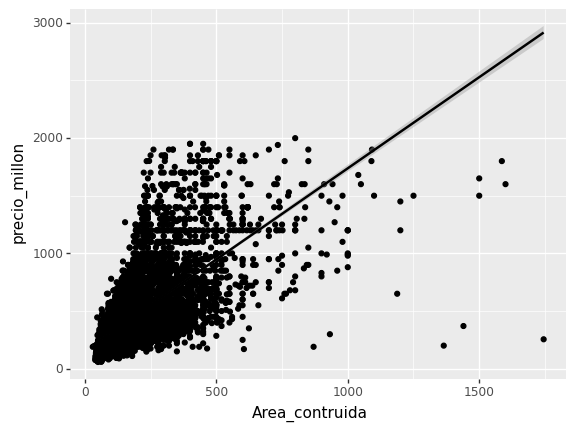

<ggplot: (132249727732)>

In [51]:
g1=ggplot(data = data) + aes(y=data["precio_millon"],x=data["Area_contruida"]) + geom_point() + geom_smooth()
g1

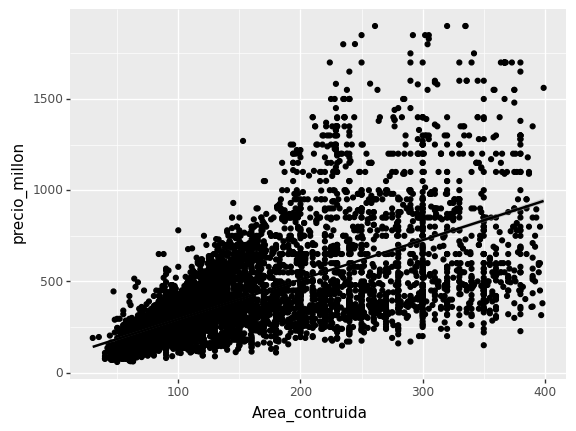

<ggplot: (132248321711)>

In [50]:
data2 =data.loc[data["Area_contruida"]<400]

g2=ggplot(data = data2) + aes(y=data2["precio_millon"],x=data2["Area_contruida"]) + geom_point() + geom_smooth()
g2

# Parseando y limpiando data

Reduciendo dimension precios

In [ ]:
data["precio(millonespesos)"] = data["Precio"]/1000000

Eliminando filas no necesarias

In [ ]:
data.drop(["ID","URL","ciudad","Cordenada_latitud", "cordenada_longitud", "Precio"], inplace=True, axis=1)

Usando barrio para definir el estrato para valores nulos

In [ ]:
est_null = data.loc[data["Estrato"].isna()]
est_replace = est_null["Barrio"].unique()

In [ ]:
for i in est_replace:
    estrato = data.loc[data["Barrio"] == i]["Estrato"].iloc[0]
    if str(estrato).isnumeric():
        pass
    else:
        estrato = 3
    toreplace = data.loc[data["Barrio"] == i]
    finalreplace = toreplace["Estrato"].astype(str).str.replace('nan', str(estrato))
    data["Estrato"].fillna(finalreplace, inplace=True)

In [ ]:
data["Estrato"] = data["Estrato"].astype('str')
data["Estrato"] = data["Estrato"].str.replace('Campestre', '6')

In [ ]:
data["Estrato"] = data["Estrato"].astype('int')

Usando barrio para definir los valores vacios de zona

In [ ]:
zon_null = data.loc[data["Zona"].isna()]
zon_replace = zon_null["Barrio"].unique()

In [ ]:
for i in zon_replace:
    zona = data.loc[data["Barrio"] == i]["Zona"].iloc[0]
    if type(zona) == str:
        pass
    else:
        zona = "Zona Centro"
    toreplace = data.loc[data["Barrio"] == i]
    finalreplace = toreplace["Zona"].astype(str).str.replace('nan', zona)
    data["Zona"].fillna(finalreplace, inplace=True)


Existe un error en el tipo en area construida y area privada también pero no se toma en cuenta por sus valores atipicos frecuentes

In [ ]:
todrop = data.loc[data["Area_contruida"] =="-"]
data.drop(todrop.index, inplace=True, axis=0)

In [ ]:
data["Area_construida"] = data["Area_contruida"].astype('str')

In [ ]:
todrop = data.loc[data["Area_construida"] =="57,40 a 60,50 "]
data.drop(todrop.index, inplace=True, axis=0)

In [ ]:
data["Area_construida"] = data["Area_construida"].astype("float")

In [ ]:
data["precio(mill)"] = data["precio(millonespesos)"]
data.drop(["precio(millonespesos)"], inplace=True, axis=1)

# Analisis exploratorio de datos

Analisis de la correlación por tipo de propiedad

In [ ]:
sns.heatmap(data.loc[data["Tipo"]=="Casa"].corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlación Casas")
plt.show()

In [ ]:
sns.heatmap(data.loc[data["Tipo"]=="Apartamento"].corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlación Apartamentos")
plt.show()

<font color="red">Nota:</font> Muestra similitud en las variables, estrato, baños y habitaciones. Pero una fuerte diferencia entre area construida y condi

In [ ]:
tipo_estrato_ind = data.pivot_table("precio(mill)","Estrato", "Tipo", 
                                    aggfunc={ max,"mean", min}).unstack().reset_index()

In [ ]:
tipo_estrato_ind= tipo_estrato_ind.rename(columns={"level_0":"Indicador", 0:"precio(mill)"}, errors="raise")

In [ ]:
tipo_estrato_ind.head(1)

In [ ]:
sns.relplot(data=tipo_estrato_ind,x="Estrato", y="precio(mill)", hue="Tipo", 
            col="Indicador", kind="line",height=4, aspect=1,col_wrap=3 )
plt.show()

<font color="red">Nota:</font> Se presenta una estandarización de las variables en el promedio y el minimo a lo largo de los estratos pero una fuerte variación en los maximos en las casas

In [ ]:
sns.relplot(data=tipo_estrato_ind,x="Indicador", y="precio(mill)", hue="Tipo", 
            col="Estrato", kind="line",height=3, aspect=1.5,col_wrap=3, 
            col_order=[1,2,3,4,5,6])
plt.show()

<font color="red">Nota:</font> Los máximos estan muy alejados de la media en cada uno de los estratos

In [ ]:
tipo_baño = data.pivot_table("precio(mill)","Baños", "Tipo",
                             aggfunc={ max,"mean", min}).unstack().reset_index()

In [ ]:
tipo_baño= tipo_baño.rename(columns={"level_0":"Indicador", 0:"precio(mill)"}, errors="raise")

In [ ]:
sns.relplot(data=tipo_baño,x="Baños", y="precio(mill)", hue="Tipo", 
            col="Indicador",height=3, aspect=1.5,col_wrap=3,kind="line")
plt.show()

<font color="red">Nota:</font> La grafica de minimos esta presentando valores atipicos en casas y apartamentos

In [ ]:
tipo_area = data.pivot_table("precio(mill)","Area_contruida", "Tipo",
                             aggfunc={ max,"mean", min}).unstack().reset_index()

In [ ]:
tipo_area= tipo_area.rename(columns={"level_0":"Indicador", 0:"precio(mill)"}, errors="raise")

In [ ]:
tipo_area.dropna(axis=0, inplace=True)

In [ ]:
sns.relplot(data=tipo_area,x="Area_contruida", y="precio(mill)", hue="Tipo", 
            col="Indicador",height=3, aspect=1.5,col_wrap=3)
plt.show()

<font color="red">Nota:</font> Valor atipico no deja percibir la información más cercana